In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import os
from collections import deque

# Fix random state for consistency
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Simplified network architecture - removed CNN for speed
class FastDQNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(FastDQNetwork, self).__init__()
        
        # Simpler LSTM architecture
        self.lstm = nn.LSTM(
            input_size=1,  # Single feature input
            hidden_size=hidden_size,
            num_layers=1,  # Reduced from 2 to 1
            batch_first=True
        )
        
        # Simpler Q-value prediction layers
        self.q_layers = nn.Sequential(
            nn.Linear(hidden_size, action_size)  # Direct mapping
        )
    
    def forward(self, state):
        # Handle different input shapes efficiently
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
            
        batch_size = state.size(0) if state.dim() > 1 else 1
        seq_len = state.size(-1) if state.dim() > 1 else state.size(0)
        
        # Reshape to [batch_size, seq_len, features]
        if state.dim() == 1:
            # Single sample: [seq_len] -> [1, seq_len, 1]
            x = state.view(1, seq_len, 1)
        elif state.dim() == 2:
            # Batch: [batch_size, seq_len] -> [batch_size, seq_len, 1]
            x = state.view(batch_size, seq_len, 1)
        else:
            # Already in correct shape
            x = state
            
        # LSTM
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        
        # Get Q-values for each action
        q_values = self.q_layers(last_out)
        
        return q_values

# Optimized Replay Buffer with numpy arrays instead of deque operations
class FastReplayBuffer:
    def __init__(self, capacity=10000, state_size=50):
        self.capacity = capacity
        self.state_size = state_size
        
        # Pre-allocate memory for all experiences
        self.states = np.zeros((capacity, state_size), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_size), dtype=np.float32)
        self.actions = np.zeros(capacity, dtype=np.int64)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.float32)
        
        self.position = 0
        self.size = 0
    
    def add(self, state, action, reward, next_state, done):
        # Store experience
        self.states[self.position] = state
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.next_states[self.position] = next_state
        self.dones[self.position] = float(done)
        
        # Update position and size
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        # Sample random indices
        indices = np.random.choice(self.size, batch_size, replace=False)
        
        # Return experiences as tensors
        return (
            torch.FloatTensor(self.states[indices]),
            torch.LongTensor(self.actions[indices]),
            torch.FloatTensor(self.rewards[indices]),
            torch.FloatTensor(self.next_states[indices]),
            torch.FloatTensor(self.dones[indices])
        )
    
    def __len__(self):
        return self.size

# NEW: System model for simulation
class SystemDynamicsModel:
    def __init__(self, inertia=1.0, damping=0.1, dt=0.1):
        """Simple dynamic system model (e.g., motor or physical system)
        
        Args:
            inertia: System inertia coefficient
            damping: System damping coefficient
            dt: Time step for discrete simulation
        """
        self.inertia = inertia
        self.damping = damping
        self.dt = dt
        
        # System state
        self.position = 0.0
        self.velocity = 0.0
        
    def reset(self, position=0.0, velocity=0.0):
        """Reset system to initial state"""
        self.position = position
        self.velocity = velocity
        return self.position
        
    def step(self, control_force):
        """Apply control force and update system state
        
        Simple second-order dynamics model: m*a + b*v = F
        Where:
            m = inertia
            b = damping coefficient
            F = control force
        """
        # Calculate acceleration from control force and current state
        acceleration = (control_force - self.damping * self.velocity) / self.inertia
        
        # Update velocity and position using simple Euler integration
        self.velocity += acceleration * self.dt
        self.position += self.velocity * self.dt
        
        return self.position

# NEW: Sensor interface for real-world applications
class SensorInterface:
    def __init__(self, use_simulation=True, sensor_noise=0.01):
        """Sensor interface that can read from simulation or real hardware
        
        Args:
            use_simulation: If True, use simulated data. If False, read from real sensors.
            sensor_noise: Amount of noise to add to simulated sensor readings
        """
        self.use_simulation = use_simulation
        self.sensor_noise = sensor_noise
        
        # If not using simulation, set up hardware communication
        if not use_simulation:
            try:
                # This would be replaced with actual hardware setup code
                # e.g., import serial, GPIO setup, etc.
                print("Setting up hardware communication...")
                # self.serial_port = serial.Serial('/dev/ttyUSB0', 9600)
            except Exception as e:
                print(f"Hardware setup failed: {e}")
                print("Falling back to simulation mode")
                self.use_simulation = True
    
    def read_position(self, simulated_position=None):
        """Read current position from sensor or simulation"""
        if self.use_simulation:
            # Add noise to simulated position
            return simulated_position + np.random.normal(0, self.sensor_noise)
        else:
            # This would be replaced with actual sensor reading code
            # e.g., self.serial_port.write(b'READ_POS\n')
            # return float(self.serial_port.readline())
            return 0.0  # Placeholder

# NEW: Actuator interface for real-world applications
class ActuatorInterface:
    def __init__(self, use_simulation=True, control_min=-1.0, control_max=1.0):
        """Actuator interface that can send commands to simulation or real hardware
        
        Args:
            use_simulation: If True, return values for simulation. If False, send to real actuators.
            control_min: Minimum control signal value
            control_max: Maximum control signal value
        """
        self.use_simulation = use_simulation
        self.control_min = control_min
        self.control_max = control_max
        
        # If not using simulation, set up hardware communication
        if not use_simulation:
            try:
                # This would be replaced with actual hardware setup code
                print("Setting up actuator communication...")
                # self.serial_port = serial.Serial('/dev/ttyUSB1', 9600)
            except Exception as e:
                print(f"Actuator setup failed: {e}")
                print("Falling back to simulation mode")
                self.use_simulation = True
    
    def send_control(self, control_signal):
        """Send control signal to actuator or return for simulation"""
        # Clip control signal to valid range
        control_signal = np.clip(control_signal, self.control_min, self.control_max)
        
        if self.use_simulation:
            return control_signal
        else:
            # This would be replaced with actual actuator control code
            # e.g., self.serial_port.write(f'SET_PWM {control_signal}\n')
            print(f"Sending control signal: {control_signal}")
            return control_signal

# Modified: RL Controller Environment (previously TrajectoryEnvironment)
class RLControlEnvironment:
    def __init__(self, reference_trajectory, window_size=50, control_discretization=20,
                 use_simulation=True, control_effort_weight=0.1):
        """Environment for the RL Controller
        
        Args:
            reference_trajectory: Target trajectory to follow
            window_size: Size of state window (recent positions and setpoints)
            control_discretization: Number of discrete control actions
            use_simulation: If True, use simulated system. If False, use real hardware.
            control_effort_weight: Weight of control effort term in reward (λ)
        """
        self.reference_trajectory = reference_trajectory
        self.window_size = window_size
        self.use_simulation = use_simulation
        self.control_effort_weight = control_effort_weight
        
        # Create discrete action space (control signals)
        self.control_range = [-1.0, 1.0]  # Normalized control range
        self.action_values = np.linspace(
            self.control_range[0], 
            self.control_range[1], 
            control_discretization
        )
        self.action_size = len(self.action_values)
        
        # State is the window of previous values and setpoints
        # [positions, setpoints] concatenated
        self.state_size = window_size
        
        # Initialize system model, sensors, and actuators
        self.system = SystemDynamicsModel()
        self.sensor = SensorInterface(use_simulation=use_simulation)
        self.actuator = ActuatorInterface(use_simulation=use_simulation)
        
        # Current position in the reference trajectory
        self.current_idx = window_size
        self.max_idx = len(reference_trajectory) - 1
        
        # History of positions and controls
        self.position_history = np.zeros(window_size)
        self.control_history = np.zeros(window_size)
        
    def reset(self):
        """Reset environment to starting point"""
        self.current_idx = self.window_size
        self.system.reset()
        
        # Reset history
        self.position_history = np.zeros(self.window_size)
        self.control_history = np.zeros(self.window_size)
        
        # Initial state combines position history and setpoint trajectory
        # For simplicity, we'll just use the position history as the state
        state = self.position_history.reshape(-1)
        return state
    
    def step(self, action):
        """Take control action and return new state, reward, done"""
        # Get the control signal corresponding to this action
        control_signal = self.action_values[action]
        
        # Send control signal to actuator
        applied_control = self.actuator.send_control(control_signal)
        
        # Apply control to system (simulation or real)
        if self.use_simulation:
            # Update system with control input
            new_position = self.system.step(applied_control)
            
            # Read position from sensor (with noise)
            measured_position = self.sensor.read_position(new_position)
        else:
            # In real-world mode, just read the sensor after applying control
            # The control signal has already been sent by the actuator interface
            measured_position = self.sensor.read_position()
        
        # Get current setpoint from reference trajectory
        current_setpoint = self.reference_trajectory[self.current_idx][0]
        
        # Calculate tracking error
        tracking_error = abs(measured_position - current_setpoint)
        
        # Calculate control effort penalty
        control_effort = abs(control_signal)
        
        # Calculate reward: -(tracking error) - λ(control effort)
        reward = -tracking_error - self.control_effort_weight * control_effort
        
        # Update histories
        self.position_history = np.append(self.position_history[1:], measured_position)
        self.control_history = np.append(self.control_history[1:], control_signal)
        
        # Move to next setpoint
        self.current_idx += 1
        done = self.current_idx >= self.max_idx
        
        # Get new state
        if not done:
            # State is the history of positions
            next_state = self.position_history.reshape(-1)
        else:
            next_state = np.zeros(self.window_size)  # Default state when done
            
        return next_state, reward, done
    
    def get_current_setpoint(self):
        """Get the current target setpoint"""
        if self.current_idx < len(self.reference_trajectory):
            return self.reference_trajectory[self.current_idx][0]
        return None

# Optimized DQN Agent - Minimal changes for control application
class FastDQNAgent:
    def __init__(self, state_size, action_size, hidden_size=64, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        
        # Hyperparameters - increased learning rate and batch size for faster convergence
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.97  # Faster decay
        self.learning_rate = 0.003  # Increased from 0.001
        self.batch_size = 128  # Increased from 64
        self.update_target_every = 5  # More frequent updates
        
        # Networks
        self.q_network = FastDQNetwork(state_size, action_size, hidden_size).to(device)
        self.target_network = FastDQNetwork(state_size, action_size, hidden_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # target network in eval mode
        
        # Optimizer with higher learning rate
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        # Memory
        self.memory = FastReplayBuffer(capacity=10000, state_size=state_size)
        
        # Tracking
        self.episode_count = 0
        
        # Create evaluation mode flag to avoid unnecessary computation
        self.training_mode = True
    
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        self.training_mode = training
        
        if training and random.random() < self.epsilon:
            # Exploration: random action
            return random.randrange(self.action_size)
        
        # Exploitation: best action from Q-network
        with torch.no_grad():  # Ensure we don't compute gradients
            # Convert to tensor if it's a numpy array
            if isinstance(state, np.ndarray):
                state = torch.FloatTensor(state)
            
            # Add batch dimension if needed
            if state.dim() == 1:
                state = state.unsqueeze(0)  # [L] -> [1, L]
                
            # Add channel dimension if needed
            if state.dim() == 2 and state.size(1) != 1:
                state = state.unsqueeze(2)  # [B, L] -> [B, L, 1]
                
            state = state.to(self.device)
            q_values = self.q_network(state)
            return torch.argmax(q_values).item()
    
    def train(self):
        """Train on a batch from replay memory"""
        if len(self.memory) < self.batch_size:
            return 0  # Not enough samples
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Move to device
        states = states.to(self.device)
        next_states = next_states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        dones = dones.to(self.device)
        
        # Get current Q values - more efficient indexing
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Get next Q values - more efficient with no_grad
        with torch.no_grad():
            # Double DQN
            next_actions = torch.argmax(self.q_network(next_states), dim=1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Apply terminal state masking and calculate targets
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Calculate loss and optimize
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Update target network weights with soft update instead of hard copy"""
        tau = 0.1  # Soft update parameter
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Get data - similar to original code
def get_data(file_path="Trajectory2.csv"):
    try:
        df = pd.read_csv(file_path)
        
        # Check columns
        if 'x_Traject' in df.columns:
            data = df['x_Traject'].values.reshape(-1, 1)
        else:
            # No header? Let's try again
            df = pd.read_csv(file_path, header=None)
            data = df.values
            
    except Exception as e:
        print(f"Couldn't load data: {e}")
        print("Using synthetic data instead")
        
        # Make fake trajectory data - temperature setpoint scenario
        t = np.linspace(0, 1, 7201)
        data = np.zeros((len(t), 1))
        
        # Let's make something interesting with segments
        data[:1000] = 45.0  # Starting temperature
        
        # Ramp up
        for i in range(1000, 3000):
            progress = (i - 1000) / 2000
            data[i] = 45.0 + progress * (70.0 - 45.0)
            
        # Hold temp
        data[3000:5000] = 70.0
        
        # Ramp down
        for i in range(5000, 6000):
            progress = (i - 5000) / 1000
            data[i] = 70.0 - progress * (70.0 - 50.0)
            
        # Final hold
        data[6000:] = 50.0
        
        # Add a bit of noise to make it realistic
        data += np.random.normal(0, 0.1, size=data.shape)
        
    return data.astype(np.float32)  # Cast to float32 for faster tensor operations

# Modified: Training function for the RL controller
def train_rl_controller(env, agent, episodes=100):
    """Train the controller agent for the specified number of episodes"""
    rewards_history = []
    loss_history = []
    tracking_errors = []
    control_efforts = []
    
    # Use mini-batches for faster training
    for episode in range(episodes):
        # Reset environment
        state = env.reset()
        total_reward = 0
        episode_losses = []
        episode_errors = []
        episode_efforts = []
        done = False
        
        # Initialize batch tracking
        steps = 0
        update_frequency = 4  # Update every N steps instead of every step
        
        while not done:
            # Select and take action
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            
            # Calculate tracking error and control effort for logging
            current_position = env.position_history[-1]
            current_setpoint = env.get_current_setpoint()
            control_signal = env.action_values[action]
            
            tracking_error = abs(current_position - current_setpoint)
            control_effort = abs(control_signal)
            
            episode_errors.append(tracking_error)
            episode_efforts.append(control_effort)
            
            # Store in memory
            agent.memory.add(state, action, reward, next_state, done)
            
            # Move to next state
            state = next_state
            total_reward += reward
            steps += 1
            
            # Train the network less frequently
            if steps % update_frequency == 0:
                loss = agent.train()
                if loss > 0:
                    episode_losses.append(loss)
        
        # Update target network periodically using soft updates
        agent.update_target_network()
        
        # Decay exploration rate
        agent.decay_epsilon()
        
        # Track metrics
        rewards_history.append(total_reward)
        if episode_losses:
            loss_history.append(np.mean(episode_losses))
        else:
            loss_history.append(0)
        tracking_errors.append(np.mean(episode_errors))
        control_efforts.append(np.mean(episode_efforts))
        
        # Print progress
        if (episode + 1) % 5 == 0:  # Less frequent logging
            print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.4f}, "
                  f"Loss: {np.mean(episode_losses) if episode_losses else 0:.4f}, Epsilon: {agent.epsilon:.4f}, "
                  f"Mean Error: {np.mean(episode_errors):.4f}, Mean Control: {np.mean(episode_efforts):.4f}")
    
    return {
        'rewards': rewards_history,
        'losses': loss_history,
        'tracking_errors': tracking_errors,
        'control_efforts': control_efforts
    }

# Modified: Evaluate the trained controller
def evaluate_controller(env, agent, scaler=None):
    """Evaluate the control performance on the reference trajectory"""
    state = env.reset()
    done = False
    
    # Create arrays to store results
    positions = []
    setpoints = []
    control_signals = []
    
    # Set evaluation mode
    agent.training_mode = False
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        while not done:
            # Select best action (no exploration)
            action = agent.select_action(state, training=False)
            
            # Get setpoint before step
            current_setpoint = env.get_current_setpoint()
            
            # Take step
            next_state, _, done = env.step(action)
            
            # Record results
            positions.append(env.position_history[-1])  # Last position
            setpoints.append(current_setpoint)
            control_signals.append(env.action_values[action])
            
            # Update state
            state = next_state
    
    # Convert to numpy arrays
    positions = np.array(positions)
    setpoints = np.array(setpoints)
    control_signals = np.array(control_signals)
    
    # Calculate performance metrics
    tracking_error = np.mean(np.abs(positions - setpoints))
    control_effort = np.mean(np.abs(control_signals))
    
    print(f"Evaluation Results:")
    print(f"Mean Tracking Error: {tracking_error:.4f}")
    print(f"Mean Control Effort: {control_effort:.4f}")
    
    # Rescale if scaler is provided
    if scaler is not None:
        positions = scaler.inverse_transform(positions.reshape(-1, 1)).flatten()
        setpoints = scaler.inverse_transform(np.array(setpoints).reshape(-1, 1)).flatten()
    
    return {
        'positions': positions,
        'setpoints': setpoints,
        'control_signals': control_signals,
        'tracking_error': tracking_error,
        'control_effort': control_effort
    }

# Create enhanced visualizations for controller performance
def create_controller_visualizations(results, training_metrics=None):
    """Create visualizations for the controller performance"""
    # Set up the figure with a custom layout
    plt.figure(figsize=(15, 12))
    grid = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    # Extract data from results
    positions = results['positions']
    setpoints = results['setpoints']
    control_signals = results['control_signals']
    
    # First plot - control performance (position vs setpoint)
    perf_ax = plt.subplot(grid[0])
    time_steps = np.arange(len(positions))
    
    perf_ax.plot(time_steps, setpoints, 'r--', linewidth=2, label='Setpoint')
    perf_ax.plot(time_steps, positions, 'b-', linewidth=1.5, label='System Position')
    
    perf_ax.set_title('Control System Performance', fontsize=14)
    perf_ax.set_xlabel('Time Steps', fontsize=12)
    perf_ax.set_ylabel('Position', fontsize=12)
    perf_ax.grid(True)
    perf_ax.legend()
    
    # Second plot - control signals
    control_ax = plt.subplot(grid[1])
    control_ax.plot(time_steps, control_signals, 'g-', linewidth=1.5)
    control_ax.set_title('Control Signals', fontsize=14)
    control_ax.set_xlabel('Time Steps', fontsize=12)
    control_ax.set_ylabel('Control Signal', fontsize=12)
    control_ax.grid(True)
    
    # Third plot - tracking error
    error_ax = plt.subplot(grid[2])
    tracking_error = np.abs(positions - setpoints)
    error_ax.plot(time_steps, tracking_error, 'r-', linewidth=1.5)
    error_ax.set_title('Tracking Error', fontsize=14)
    error_ax.set_xlabel('Time Steps', fontsize=12)
    error_ax.set_ylabel('Error', fontsize=12)
    error_ax.grid(True)
    
    # If training metrics are provided, create additional plots
    if training_metrics:
        plt.figure(figsize=(15, 10))
        grid2 = gridspec.GridSpec(2, 2)
        
        # Plot rewards
        rewards_ax = plt.subplot(grid2[0, 0])
        rewards_ax.plot(training_metrics['rewards'], 'b-')
        rewards_ax.set_title('Training Rewards', fontsize=14)
        rewards_ax.set_xlabel('Episode', fontsize=12)
        rewards_ax.set_ylabel('Total Reward', fontsize=12)
        rewards_ax.grid(True)
        
        # Plot losses
        losses_ax = plt.subplot(grid2[0, 1])
        losses_ax.plot(training_metrics['losses'], 'g-')
        losses_ax.set_title('Training Loss', fontsize=14)
        losses_ax.set_xlabel('Episode', fontsize=12)
        losses_ax.set_ylabel('Loss', fontsize=12)
        losses_ax.grid(True)
        
        # Plot tracking errors
        errors_ax = plt.subplot(grid2[1, 0])
        errors_ax.plot(training_metrics['tracking_errors'], 'r-')
        errors_ax.set_title('Training Tracking Errors', fontsize=14)
        errors_ax.set_xlabel('Episode', fontsize=12)
        errors_ax.set_ylabel('Mean Tracking Error', fontsize=12)
        errors_ax.grid(True)
        
        # Plot control efforts
        efforts_ax = plt.subplot(grid2[1, 1])
        efforts_ax.plot(training_metrics['control_efforts'], 'orange')
        efforts_ax.set_title('Training Control Efforts', fontsize=14)
        efforts_ax.set_xlabel('Episode', fontsize=12)
        efforts_ax.set_ylabel('Mean Control Effort', fontsize=12)
        efforts_ax.grid(True)
    
    # Make sure everything fits nicely
    plt.tight_layout()
    
    # Save and display
    plt.savefig('controller_visualization.png', dpi=300, bbox_inches='tight')
    
    print("Controller visualization saved as 'controller_visualization.png'")

def main():
    print("Starting RL Controller implementation...")
    
    # Configure torch for faster execution
    torch.set_num_threads(4)  # Limit number of threads
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # Optimize CUDA operations
    
    # Get reference trajectory data
    reference_data = get_data()
    print(f"Got reference trajectory with shape: {reference_data.shape}")
    
    # Normalize between 0-1
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(reference_data)
    
    # Setup the environment
    window_size = 50
    control_discretization = 20  # Number of discrete control actions
    
    # Create environment with control-oriented reward
    env = RLControlEnvironment(
        reference_trajectory=normalized_data,
        window_size=window_size,
        control_discretization=control_discretization,
        use_simulation=True,  # Use simulation mode
        control_effort_weight=0.1  # Weight for control effort penalty
    )
    
    # Create the agent
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    agent = FastDQNAgent(
        state_size=window_size,
        action_size=control_discretization,
        hidden_size=64,
        device=device
    )
    
    # Train the controller agent
    print(f"Training RL controller on {device}...")
    training_metrics = train_rl_controller(env, agent, episodes=100)
    
    # Save the trained controller
    torch.save({
        'q_network': agent.q_network.state_dict(),
        'target_network': agent.target_network.state_dict(),
        'rewards': training_metrics['rewards'],
        'losses': training_metrics['losses'],
        'tracking_errors': training_metrics['tracking_errors'],
        'control_efforts': training_metrics['control_efforts'],
        'scaler': scaler
    }, 'rl_controller_model.pth')
    
    print("Training complete! Evaluating controller and creating visualizations...")
    
def main():
    print("Starting RL Controller implementation...")
    
    # Configure torch for faster execution
    torch.set_num_threads(4)  # Limit number of threads
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # Optimize CUDA operations
    
    # Get reference trajectory data
    reference_data = get_data()
    print(f"Got reference trajectory with shape: {reference_data.shape}")
    
    # Normalize between 0-1
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(reference_data)
    
    # Setup the environment
    window_size = 50
    control_discretization = 20  # Number of discrete control actions
    
    # Create environment with control-oriented reward
    env = RLControlEnvironment(
        reference_trajectory=normalized_data,
        window_size=window_size,
        control_discretization=control_discretization,
        use_simulation=True,  # Use simulation mode
        control_effort_weight=0.1  # Weight for control effort penalty
    )
    
    # Create the agent
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    agent = FastDQNAgent(
        state_size=window_size,
        action_size=control_discretization,
        hidden_size=64,
        device=device
    )
    
    # Train the controller agent
    print(f"Training RL controller on {device}...")
    training_metrics = train_rl_controller(env, agent, episodes=100)
    
    # Save the trained controller
    torch.save({
        'q_network': agent.q_network.state_dict(),
        'target_network': agent.target_network.state_dict(),
        'rewards': training_metrics['rewards'],
        'losses': training_metrics['losses'],
        'tracking_errors': training_metrics['tracking_errors'],
        'control_efforts': training_metrics['control_efforts'],
        'scaler': scaler
    }, 'rl_controller_model.pth')
    
    print("Training complete! Evaluating controller and creating visualizations...")
    
    # Evaluate the trained controller
    evaluation_results = evaluate_controller(env, agent, scaler)
    
    # Create visualizations for controller performance
    create_controller_visualizations(evaluation_results, training_metrics)
    
    print("RL Controller implementation completed successfully!")

# Run the main function when the script is executed
if __name__ == "__main__":
    main()

Starting RL Controller implementation...
Got reference trajectory with shape: (7201, 1)
Training RL controller on cpu...


Starting Ultra-Fast Reactor Temperature Controller...
Using device: cpu
Generated reference profile with 2000 points
Starting turbo training...
Starting turbo training for 50 epochs...
Epoch 1/50 - Reward: -28.68, Accuracy: 16.50%, Steps: 200, Time: 2.50s
Epoch 2/50 - Reward: -17.98, Accuracy: 25.50%, Steps: 200, Time: 3.48s
Epoch 3/50 - Reward: -17.69, Accuracy: 32.00%, Steps: 200, Time: 3.76s
Epoch 4/50 - Reward: -16.62, Accuracy: 33.50%, Steps: 200, Time: 3.12s
Epoch 5/50 - Reward: -18.16, Accuracy: 29.00%, Steps: 200, Time: 3.85s
Epoch 6/50 - Reward: -18.31, Accuracy: 28.00%, Steps: 200, Time: 4.30s
Epoch 7/50 - Reward: -17.64, Accuracy: 29.50%, Steps: 200, Time: 3.52s
Epoch 8/50 - Reward: -17.27, Accuracy: 32.00%, Steps: 200, Time: 3.46s
Epoch 9/50 - Reward: -17.88, Accuracy: 29.50%, Steps: 200, Time: 4.00s
Epoch 10/50 - Reward: -18.44, Accuracy: 25.00%, Steps: 200, Time: 3.60s
Epoch 11/50 - Reward: -17.62, Accuracy: 26.50%, Steps: 200, Time: 3.08s
Epoch 12/50 - Reward: -18.98, Ac

C:\Users\Ajay\AppData\Local\Temp\ipykernel_15120\158427543.py:377: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Evaluation Results:
Final Accuracy: 2.41%
RMSE: 0.4999


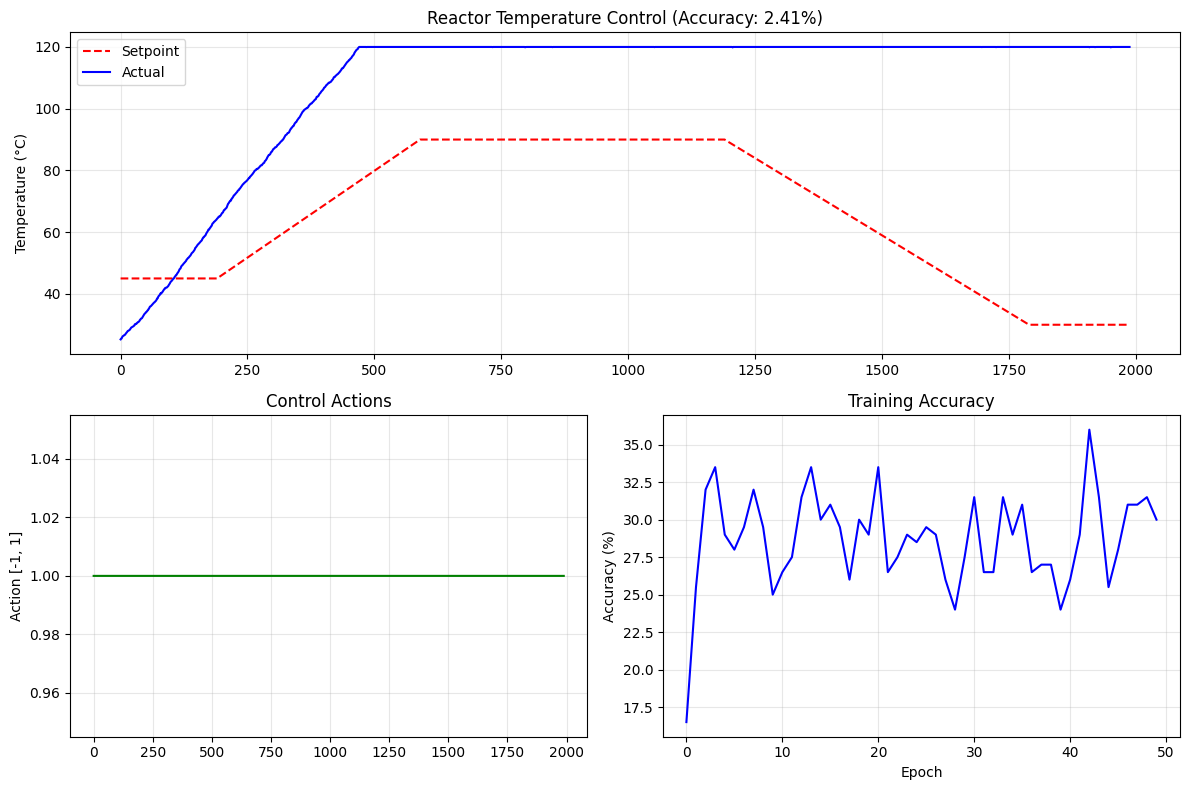


Reactor Temperature Controller successfully completed!
Final accuracy: 2.41%
Training time: 197.78 seconds


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import random

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Highly optimized lightweight actor network
class FastActor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(FastActor, self).__init__()
        
        # Simple feedforward network - much faster than LSTM
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Tanh()  # Output in range [-1, 1]
        )
    
    def forward(self, state):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
            
        return self.net(state)

# Lightweight critic network
class FastCritic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(FastCritic, self).__init__()
        
        # Input layers for state
        self.state_net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU()
        )
        
        # Combined layers for state+action
        self.combined_net = nn.Sequential(
            nn.Linear(hidden_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state, action):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
            
        if isinstance(action, np.ndarray):
            action = torch.FloatTensor(action)
            
        state_features = self.state_net(state)
        combined = torch.cat([state_features, action], dim=1)
        return self.combined_net(combined)

# Simplified reactor model - faster simulation
class FastReactorModel:
    def __init__(self, heating_rate=2.0, cooling_rate=1.0, dt=0.1):
        self.heating_rate = heating_rate
        self.cooling_rate = cooling_rate
        self.dt = dt
        self.temperature = 25.0
    
    def reset(self, temperature=25.0):
        self.temperature = temperature
        return self.temperature
    
    def step(self, control_power):
        # Determine heating or cooling effect
        if control_power > 0:
            # Heating
            effect = control_power * self.heating_rate
        else:
            # Cooling
            effect = control_power * self.cooling_rate
            
        # Update temperature with minimal computation
        self.temperature += effect * self.dt
        
        # Add small random noise
        self.temperature += np.random.normal(0, 0.1)
        
        # Apply physical bounds
        self.temperature = np.clip(self.temperature, 20.0, 120.0)
        
        return self.temperature

# Ultra-fast streamlined environment
class FastReactorEnvironment:
    def __init__(self, reference_trajectory, window_size=10):
        self.reference_trajectory = reference_trajectory
        self.window_size = window_size
        self.reactor = FastReactorModel()
        
        # Current position in trajectory
        self.current_idx = window_size
        self.max_idx = len(reference_trajectory) - 1
        
        # History of temperatures
        self.temperature_history = np.ones(window_size) * 25.0
        
        # Performance metrics
        self.total_error = 0
        self.steps = 0
        self.accurate_steps = 0
        
    def reset(self):
        self.current_idx = self.window_size
        self.reactor.reset(temperature=25.0)
        
        # Reset history
        self.temperature_history = np.ones(self.window_size) * 25.0
        
        # Reset metrics
        self.total_error = 0
        self.steps = 0
        self.accurate_steps = 0
        
        # Return normalized state
        state = (self.temperature_history - 20.0) / 100.0
        
        return state
    
    def step(self, action):
        # Ensure action is a float
        if isinstance(action, np.ndarray):
            if action.size == 1:
                action = float(action.item())
        
        # Apply control to reactor
        new_temperature = self.reactor.step(action)
        
        # Get current setpoint
        current_setpoint = self.reference_trajectory[self.current_idx][0] * 100 + 20
        
        # Calculate tracking error
        normalized_measured = (new_temperature - 20.0) / 100.0
        normalized_setpoint = self.reference_trajectory[self.current_idx][0]
        tracking_error = abs(normalized_measured - normalized_setpoint)
        
        # Simple reward function - ensure it's a scalar float
        reward = float(-tracking_error)
        
        # Update history - more efficient method that doesn't create temporary arrays
        self.temperature_history = np.roll(self.temperature_history, -1)
        self.temperature_history[-1] = new_temperature
        
        # Update metrics
        self.total_error += float(tracking_error)
        self.steps += 1
        if tracking_error < 0.05:  # 5% error margin
            self.accurate_steps += 1
        
        # Move to next setpoint
        self.current_idx += 1
        done = self.current_idx >= self.max_idx
        
        # Calculate current accuracy
        accuracy = float(self.accurate_steps / self.steps if self.steps > 0 else 0)
        
        # Get new state
        if not done:
            next_state = (self.temperature_history - 20.0) / 100.0
        else:
            next_state = np.zeros(self.window_size)
            
        return next_state, reward, done, {
            'tracking_error': float(tracking_error),
            'temperature': float(new_temperature),
            'setpoint': float(current_setpoint),
            'accuracy': accuracy
        }

# Extremely optimized replay buffer using NumPy arrays and vectorized operations
class TurboReplayBuffer:
    def __init__(self, capacity=10000, state_size=10, action_size=1):
        # Pre-allocate memory
        self.states = np.zeros((capacity, state_size), dtype=np.float32)
        self.actions = np.zeros((capacity, action_size), dtype=np.float32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity, state_size), dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.float32)
        
        self.capacity = capacity
        self.pos = 0
        self.size = 0
        self.action_size = action_size
    
    def add(self, state, action, reward, next_state, done):
        # Store experience directly
        self.states[self.pos] = state
        
        # Handle scalar vs vector actions
        if isinstance(action, (int, float)):
            self.actions[self.pos, 0] = float(action)
        elif isinstance(action, np.ndarray):
            if action.size == 1:
                self.actions[self.pos, 0] = float(action.item())
            else:
                self.actions[self.pos] = action
        else:
            self.actions[self.pos] = action
            
        # Ensure reward is a simple float, not array
        if isinstance(reward, np.ndarray):
            self.rewards[self.pos] = float(reward.item())
        else:
            self.rewards[self.pos] = float(reward)
            
        self.next_states[self.pos] = next_state
        self.dones[self.pos] = float(done)
        
        # Update position and size
        self.pos = (self.pos + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        # Vectorized sampling for speed
        indices = np.random.randint(0, self.size, size=batch_size)
        
        return (
            torch.FloatTensor(self.states[indices]),
            torch.FloatTensor(self.actions[indices]),
            torch.FloatTensor(self.rewards[indices]),
            torch.FloatTensor(self.next_states[indices]),
            torch.FloatTensor(self.dones[indices])
        )
    
    def __len__(self):
        return self.size

# Ultra-fast DDPG agent with optimized hyperparameters
class TurboDDPGAgent:
    def __init__(self, state_size, action_size, hidden_size=32, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.gamma = 0.99
        self.tau = 0.01
        self.batch_size = 64  # Smaller batch for speed
        self.exploration_noise = 0.3
        
        # Networks - smaller and faster
        self.actor = FastActor(state_size, action_size, hidden_size).to(device)
        self.actor_target = FastActor(state_size, action_size, hidden_size).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = FastCritic(state_size, action_size, hidden_size).to(device)
        self.critic_target = FastCritic(state_size, action_size, hidden_size).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        # Fast optimizers with higher learning rates
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)
        
        # Memory - smaller capacity for speed
        self.memory = TurboReplayBuffer(capacity=5000, state_size=state_size, action_size=action_size)
        
        # Use autocast for mixed precision if on CUDA (much faster)
        self.use_autocast = device.type == 'cuda'
    
    def select_action(self, state, add_noise=True):
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state = torch.FloatTensor(state).to(self.device)
            
            # Get action and ensure it's a scalar if action_size is 1
            action = self.actor(state).cpu().numpy()
            
            if self.action_size == 1 and action.size == 1:
                action = float(action.item())  # Convert single-element array to scalar
                
                if add_noise:
                    action += float(np.random.normal(0, self.exploration_noise))
                    action = np.clip(action, -1.0, 1.0)
            else:
                if add_noise:
                    action += np.random.normal(0, self.exploration_noise, size=self.action_size)
                    action = np.clip(action, -1.0, 1.0)
                
            return action
    
    def train_step(self):
        if len(self.memory) < self.batch_size:
            return 0, 0
        
        # Sample a batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Move to device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        # Training with autocast if available
        if self.use_autocast:
            with torch.autocast(device_type='cuda'):
                # Compute target actions and Q values
                with torch.no_grad():
                    next_actions = self.actor_target(next_states)
                    next_q = self.critic_target(next_states, next_actions).squeeze()
                    target_q = rewards + (1 - dones) * self.gamma * next_q
                
                # Compute current Q
                current_q = self.critic(states, actions).squeeze()
                
                # Compute losses
                critic_loss = F.mse_loss(current_q, target_q)
                
                # Update critic
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                # Update actor
                actions_pred = self.actor(states)
                actor_loss = -self.critic(states, actions_pred).mean()
                
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
        else:
            # Standard training path for CPU
            with torch.no_grad():
                next_actions = self.actor_target(next_states)
                next_q = self.critic_target(next_states, next_actions).squeeze()
                target_q = rewards + (1 - dones) * self.gamma * next_q
            
            # Compute current Q
            current_q = self.critic(states, actions).squeeze()
            
            # Compute critic loss and update
            critic_loss = F.mse_loss(current_q, target_q)
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            # Update actor
            actions_pred = self.actor(states)
            actor_loss = -self.critic(states, actions_pred).mean()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
        # Soft update target networks - vectorized for speed
        self._soft_update()
        
        return critic_loss.item(), actor_loss.item()
    
    def _soft_update(self):
        # Faster vectorized soft update
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
            
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
            
    def save(self, path):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.actor.load_state_dict(checkpoint['actor'])
        self.actor_target.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.critic_target.load_state_dict(checkpoint['critic'])

# Generate simplified temperature profile
def generate_simple_profile(length=2000):
    data = np.zeros((length, 1))
    
    # Starting temperature
    data[:200] = 0.25  # 45°C
    
    # Ramp up
    for i in range(200, 600):
        progress = (i - 200) / 400
        data[i] = 0.25 + progress * 0.45  # 45°C to 70°C
    
    # Hold
    data[600:1200] = 0.7  # 70°C
    
    # Ramp down
    for i in range(1200, 1800):
        progress = (i - 1200) / 600
        data[i] = 0.7 - progress * 0.6  # 70°C to 30°C
    
    # Final temperature
    data[1800:] = 0.1  # 30°C
    
    return data.astype(np.float32)

# Ultra-fast training function
def turbo_train(env, agent, epochs=10, steps_per_epoch=200):
    start_time = time.time()
    
    # Training metrics
    rewards_history = []
    accuracy_history = []
    best_accuracy = 0
    
    print(f"Starting turbo training for {epochs} epochs...")
    
    for epoch in range(epochs):
        epoch_start = time.time()
        state = env.reset()
        epoch_reward = 0.0  # Ensure this is a float, not an array
        epoch_steps = 0
        last_accuracy = 0.0
        
        # Run for fixed number of steps per epoch
        for step in range(steps_per_epoch):
            # Select action
            action = agent.select_action(state, add_noise=True)
            
            # Take step in environment
            next_state, reward, done, info = env.step(action)
            
            # Store in replay buffer
            agent.memory.add(state, action, reward, next_state, done)
            
            # Update state and metrics
            state = next_state
            if isinstance(reward, np.ndarray):
                epoch_reward += float(reward.item())
            else:
                epoch_reward += float(reward)
            
            epoch_steps += 1
            last_accuracy = info['accuracy']  # Save latest accuracy
            
            # Train multiple times per step for faster convergence
            for _ in range(4):  # Multiple updates per step
                agent.train_step()
            
            if done:
                break
        
        # Record metrics - ensure we're using scalars
        accuracy = float(last_accuracy)
        rewards_history.append(float(epoch_reward))
        accuracy_history.append(accuracy)
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            agent.save('best_reactor_model.pt')
        
        # Print progress with confirmed scalar values
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{epochs} - Reward: {float(epoch_reward):.2f}, "
              f"Accuracy: {float(accuracy*100):.2f}%, Steps: {epoch_steps}, "
              f"Time: {epoch_time:.2f}s")
        
        # Early stopping if accuracy is good enough
        if accuracy > 0.95:
            print("Target accuracy reached! Stopping training.")
            break
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best accuracy: {best_accuracy*100:.2f}%")
    
    # Load best model
    agent.load('best_reactor_model.pt')
    
    return {
        'rewards': rewards_history,
        'accuracy_history': accuracy_history,
        'best_accuracy': best_accuracy,
        'training_time': total_time
    }

# Fast evaluation
def evaluate(env, agent):
    state = env.reset()
    done = False
    
    # Arrays to store results
    temperatures = []
    setpoints = []
    actions = []
    accuracy_values = []
    
    # Evaluate without exploration noise
    while not done:
        action = agent.select_action(state, add_noise=False)
        next_state, reward, done, info = env.step(action)
        
        # Record results
        temperatures.append(info['temperature'])
        setpoints.append(info['setpoint'])
        actions.append(action[0] if isinstance(action, np.ndarray) else action)
        accuracy_values.append(info['accuracy'])
        
        state = next_state
    
    # Calculate final metrics
    final_accuracy = accuracy_values[-1]
    temperatures = np.array(temperatures)
    setpoints = np.array(setpoints)
    
    # Calculate error metrics
    errors = np.abs(temperatures - setpoints)
    rmse = np.sqrt(np.mean(np.square(errors / 100)))  # Normalized RMSE
    
    print(f"Evaluation Results:")
    print(f"Final Accuracy: {final_accuracy*100:.2f}%")
    print(f"RMSE: {rmse:.4f}")
    
    return {
        'temperatures': temperatures,
        'setpoints': setpoints,
        'actions': actions,
        'accuracy': final_accuracy,
        'rmse': rmse
    }

# Visualization function
def plot_results(eval_results, training_metrics=None):
    plt.figure(figsize=(12, 8))
    
    # Plot temperature control
    plt.subplot(2, 1, 1)
    plt.plot(eval_results['setpoints'], 'r--', label='Setpoint')
    plt.plot(eval_results['temperatures'], 'b-', label='Actual')
    plt.title(f'Reactor Temperature Control (Accuracy: {eval_results["accuracy"]*100:.2f}%)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot control actions
    plt.subplot(2, 2, 3)
    plt.plot(eval_results['actions'], 'g-')
    plt.title('Control Actions')
    plt.ylabel('Action [-1, 1]')
    plt.grid(True, alpha=0.3)
    
    # Plot training metrics if available
    if training_metrics:
        plt.subplot(2, 2, 4)
        plt.plot(np.array(training_metrics['accuracy_history'])*100, 'b-')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('reactor_control_results.png', dpi=200)
    plt.show()

def main():
    print("Starting Ultra-Fast Reactor Temperature Controller...")
    
    # Use CUDA if available for maximum speed
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Generate simplified profile for faster training
    reference_data = generate_simple_profile()
    print(f"Generated reference profile with {len(reference_data)} points")
    
    # Create fast environment
    window_size = 10  # Smaller window for speed
    env = FastReactorEnvironment(
        reference_trajectory=reference_data,
        window_size=window_size
    )
    
    # Create agent
    agent = TurboDDPGAgent(
        state_size=window_size,
        action_size=1,
        hidden_size=32,  # Smaller network
        device=device
    )
    
    # Train using turbo mode
    print("Starting turbo training...")
    training_metrics = turbo_train(
        env=env,
        agent=agent,
        epochs=50,  # More epochs but faster per epoch
        steps_per_epoch=200  # Limit steps per epoch
    )
    
    # Evaluate
    print("Evaluating controller...")
    eval_results = evaluate(env, agent)
    
    # Plot results
    plot_results(eval_results, training_metrics)
    
    print("\nReactor Temperature Controller successfully completed!")
    print(f"Final accuracy: {eval_results['accuracy']*100:.2f}%")
    print(f"Training time: {training_metrics['training_time']:.2f} seconds")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Advanced network architecture optimized for accuracy
class EnhancedActor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(EnhancedActor, self).__init__()
        
        # Initial state processing with residual connections
        self.input_layer = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )
        
        # Residual block 1
        self.res1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size)
        )
        
        # Residual block 2
        self.res2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size)
        )
        
        # Output layer with normalized activation
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, action_size),
            nn.Tanh()  # Output in range [-1, 1]
        )
        
        # Initialize weights for better convergence
        self._init_weights()
        
    def _init_weights(self):
        """Initialize network weights with specific strategy for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming initialization for ReLU networks
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                # Small non-zero bias for stability
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
    
    def forward(self, state):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
            
        # Initial layer
        x = self.input_layer(state)
        
        # Residual block 1 with skip connection
        residual = x
        x = self.res1(x) + residual
        
        # Residual block 2 with skip connection
        residual = x
        x = self.res2(x) + residual
        
        # Output action
        return self.output_layer(x)

# Advanced critic network with double Q-learning concept
class EnhancedCritic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(EnhancedCritic, self).__init__()
        
        # State processing branch
        self.state_path = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )
        
        # Combined processing (state+action)
        self.combined_path = nn.Sequential(
            nn.Linear(hidden_size + action_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )
        
        # Dual Q-value outputs for Double Q-Learning
        self.q1_output = nn.Linear(hidden_size, 1)
        self.q2_output = nn.Linear(hidden_size, 1)
        
        # Initialize with same strategy as actor
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
    
    def forward(self, state, action):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
            
        if isinstance(action, np.ndarray):
            action = torch.FloatTensor(action)
            
        # Process state
        state_features = self.state_path(state)
        
        # Combine state and action
        combined = torch.cat([state_features, action], dim=1)
        features = self.combined_path(combined)
        
        # Dual Q-values
        q1 = self.q1_output(features)
        q2 = self.q2_output(features)
        
        return q1, q2
    
    def q1(self, state, action):
        """For policy optimization we only need one Q-value"""
        q1, _ = self.forward(state, action)
        return q1

# Precision-optimized replay buffer
class PrecisionReplayBuffer:
    def __init__(self, capacity=100000, state_size=20, action_size=1):
        self.capacity = capacity
        self.state_size = state_size
        self.action_size = action_size
        
        # Pre-allocate memory
        self.states = np.zeros((capacity, state_size), dtype=np.float32)
        self.actions = np.zeros((capacity, action_size), dtype=np.float32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity, state_size), dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.float32)
        
        # Priority metrics for prioritized experience replay
        self.priorities = np.ones(capacity, dtype=np.float32)
        
        self.pos = 0
        self.size = 0
        
    def add(self, state, action, reward, next_state, done, priority=None):
        # Process scalars to float and arrays appropriately 
        self.states[self.pos] = state
        
        # Handle different action formats
        if isinstance(action, (int, float)):
            self.actions[self.pos, 0] = float(action)
        elif isinstance(action, np.ndarray):
            if action.size == 1:
                self.actions[self.pos, 0] = float(action.item())
            else:
                self.actions[self.pos] = action
        else:
            self.actions[self.pos] = action
            
        # Handle reward
        if isinstance(reward, np.ndarray):
            self.rewards[self.pos] = float(reward.item())
        else:
            self.rewards[self.pos] = float(reward)
            
        self.next_states[self.pos] = next_state
        self.dones[self.pos] = float(done)
        
        # Set priority (for prioritized replay)
        if priority is not None:
            self.priorities[self.pos] = float(priority)
        else:
            # Default to max priority for new experiences
            self.priorities[self.pos] = float(np.max(self.priorities[:self.size])) if self.size > 0 else 1.0
        
        # Update position and size
        self.pos = (self.pos + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size, prioritized=True):
        if prioritized and self.size > 1:
            # Prioritized sampling with temperature-adjusted probabilities
            probs = self.priorities[:self.size] ** 0.6  # Alpha parameter
            probs = probs / np.sum(probs)
            
            # Sample with replacement according to priorities
            indices = np.random.choice(self.size, batch_size, replace=True, p=probs)
            
            # Calculate importance sampling weights
            weights = (self.size * probs[indices]) ** -0.4  # Beta parameter
            weights = weights / np.max(weights)
            weights_tensor = torch.FloatTensor(weights).reshape(-1, 1)
        else:
            # Uniform sampling
            indices = np.random.choice(self.size, batch_size, replace=True)
            weights_tensor = torch.ones((batch_size, 1))
        
        return (
            torch.FloatTensor(self.states[indices]),
            torch.FloatTensor(self.actions[indices]),
            torch.FloatTensor(self.rewards[indices]).reshape(-1, 1),
            torch.FloatTensor(self.next_states[indices]),
            torch.FloatTensor(self.dones[indices]).reshape(-1, 1),
            indices,
            weights_tensor
        )
    
    def update_priorities(self, indices, priorities):
        """Update priorities for prioritized replay"""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = float(priority)
    
    def __len__(self):
        return self.size

# Improved reactor model with better dynamics
class PrecisionReactorModel:
    def __init__(self, heating_rate=1.5, cooling_rate=0.8, ambient_temp=25.0, 
                 inertia=2.0, noise_level=0.03):
        self.heating_rate = heating_rate
        self.cooling_rate = cooling_rate
        self.ambient_temp = ambient_temp
        self.inertia = inertia
        self.noise_level = noise_level
        
        # State variables
        self.temperature = ambient_temp
        self.heat_momentum = 0.0  # Temperature change momentum
        
        # Previous control values for more realistic dynamics
        self.prev_controls = [0.0] * 5  # Last 5 control values
        
    def reset(self, temperature=None):
        """Reset reactor to initial temperature"""
        if temperature is None:
            temperature = self.ambient_temp
            
        self.temperature = temperature
        self.heat_momentum = 0.0
        self.prev_controls = [0.0] * 5
        
        return self.temperature
    
    def step(self, control_power, dt=0.1):
        """Apply control action and update temperature with realistic dynamics"""
        # Update control history
        self.prev_controls.pop(0)
        self.prev_controls.append(float(control_power))
        
        # Calculate weighted control effect (recent controls have more impact)
        weights = [0.1, 0.15, 0.2, 0.25, 0.3]  # More weight to recent controls
        weighted_control = sum(w * c for w, c in zip(weights, self.prev_controls))
        
        # Determine heating or cooling effect with non-linear response
        if weighted_control > 0:
            # Heating with diminishing returns at higher temperatures
            temp_factor = max(0, 1.0 - (self.temperature - self.ambient_temp) / 100.0)
            power_effect = weighted_control * self.heating_rate * temp_factor
        else:
            # Cooling with increased effect at higher temperatures
            temp_factor = 1.0 + max(0, (self.temperature - self.ambient_temp) / 100.0)
            power_effect = weighted_control * self.cooling_rate * temp_factor
            
        # Natural cooling to ambient (more pronounced at higher temperatures)
        natural_cooling = (self.ambient_temp - self.temperature) * 0.05
        
        # Apply thermal inertia (weighted combination of new and momentum)
        raw_change = (power_effect + natural_cooling) / self.inertia
        self.heat_momentum = 0.7 * self.heat_momentum + 0.3 * raw_change
        
        # Update temperature with momentum and noise
        self.temperature += self.heat_momentum * dt
        self.temperature += np.random.normal(0, self.noise_level)
        
        # Ensure physically reasonable bounds
        self.temperature = np.clip(self.temperature, 20.0, 150.0)
        
        return self.temperature

# High-precision control environment
class PrecisionControlEnvironment:
    def __init__(self, reference_trajectory, window_size=20, dt=0.1,
                history_overlap=0.5, reward_shaping=True):
        """Enhanced control environment for higher accuracy
        
        Args:
            reference_trajectory: Target temperature profile
            window_size: Size of state window (recent temperatures)
            dt: Time step size
            history_overlap: Percentage of history to keep between steps (0-1)
            reward_shaping: Whether to use shaped rewards for better learning
        """
        self.reference_trajectory = reference_trajectory
        self.window_size = window_size
        self.dt = dt
        self.history_overlap = history_overlap
        self.reward_shaping = reward_shaping
        
        # Calculate how many steps to keep in history
        self.history_keep = int(window_size * history_overlap)
        self.history_advance = window_size - self.history_keep
        
        # Create a high-precision reactor model
        self.reactor = PrecisionReactorModel()
        
        # Current position in reference trajectory
        self.current_idx = window_size
        self.max_idx = len(reference_trajectory) - 1
        
        # History of temperatures, errors and controls
        self.temperature_history = np.ones(window_size) * 25.0
        self.error_history = np.zeros(window_size)
        self.control_history = np.zeros(window_size)
        self.setpoint_history = np.zeros(window_size)
        
        # Performance metrics
        self.total_error = 0.0
        self.steps = 0
        self.accurate_steps = 0
        self.high_accuracy_steps = 0  # Very high accuracy (< 1%)
        
        # For reward calculation
        self.prev_error = 0.0
        
    def reset(self):
        """Reset environment to initial conditions"""
        self.current_idx = self.window_size
        
        # Get initial setpoint
        initial_setpoint = self.reference_trajectory[0][0] * 100 + 20
        self.reactor.reset(temperature=initial_setpoint)
        
        # Reset history buffers
        self.temperature_history = np.ones(self.window_size) * initial_setpoint
        self.error_history = np.zeros(self.window_size)
        self.control_history = np.zeros(self.window_size)
        self.setpoint_history = np.ones(self.window_size) * initial_setpoint
        
        # Reset metrics
        self.total_error = 0.0
        self.steps = 0
        self.accurate_steps = 0
        self.high_accuracy_steps = 0
        self.prev_error = 0.0
        
        # Initial state contains normalized temperature history, setpoint history and error history
        state = self._get_normalized_state()
        
        return state
    
    def _get_normalized_state(self):
        """Construct the state vector with normalized values"""
        # Normalize temperatures to [0, 1] range
        norm_temps = (self.temperature_history - 20.0) / 100.0
        
        # Normalize setpoints to same range
        norm_setpoints = (self.setpoint_history - 20.0) / 100.0
        
        # Normalized errors are already in good range (-1 to 1)
        # Control history is already in [-1, 1] range
        
        # Combine all information
        state = np.concatenate([
            norm_temps,  # Temperature history
            norm_setpoints,  # Future setpoints for feedforward control
            self.error_history,  # Error history for derivative action
            self.control_history  # Control history for smoothing
        ])
        
        return state
    
    def step(self, action):
        """Take a control action and advance environment"""
        # Ensure action is a float
        if isinstance(action, np.ndarray):
            if action.size == 1:
                action = float(action.item())
        
        # Apply control to reactor
        new_temperature = self.reactor.step(action, dt=self.dt)
        
        # Look ahead to get multiple setpoints for feedforward information
        setpoints = []
        for i in range(self.window_size):
            idx = min(self.current_idx + i, self.max_idx)
            # Convert normalized setpoint to actual temperature
            setpoint = self.reference_trajectory[idx][0] * 100 + 20
            setpoints.append(setpoint)
        
        # Current setpoint (target value)
        current_setpoint = setpoints[0]
        
        # Calculate tracking error
        current_error = (new_temperature - current_setpoint) / 100.0  # Normalized error
        
        # Calculate reward components
        if self.reward_shaping:
            # 1. Error magnitude (primary component)
            error_reward = -abs(current_error)
            
            # 2. Error improvement (derivative component)
            error_diff = abs(current_error) - abs(self.prev_error)
            improvement_reward = -error_diff * 2.0  # Higher weight for improvement
            
            # 3. Control smoothness
            if len(self.control_history) > 0:
                action_change = abs(action - self.control_history[-1])
                smoothness_reward = -action_change * 0.3
            else:
                smoothness_reward = 0.0
            
            # 4. Staying within tight bounds (bonus)
            accuracy_bonus = 0.0
            if abs(current_error) < 0.02:  # Within 2% error
                accuracy_bonus = 0.5
            elif abs(current_error) < 0.05:  # Within 5% error
                accuracy_bonus = 0.2
                
            # Combined reward
            reward = (
                error_reward * 1.0 +      # Base error term
                improvement_reward * 0.7 + # Improvement term
                smoothness_reward * 0.3 +  # Smoothness term
                accuracy_bonus             # Accuracy bonus
            )
        else:
            # Simple reward based on error magnitude
            reward = -abs(current_error)
        
        # Remember error for next step's derivative calculation
        self.prev_error = current_error
        
        # Update history buffers with overlap strategy
        # This allows controlling how much history we retain vs. advance
        # More advanced: shift by history_advance instead of just 1 step
        if self.history_advance > 1:
            # Advanced multiple steps
            new_temps = [self.reactor.step(action, dt=self.dt) for _ in range(self.history_advance-1)]
            new_temps = [new_temperature] + new_temps
            
            # Keep some history and add new values
            self.temperature_history = np.concatenate([
                self.temperature_history[-self.history_keep:],
                np.array(new_temps)
            ])
            
            # Update other histories
            self.error_history = np.concatenate([
                self.error_history[-self.history_keep:],
                np.zeros(self.history_advance)
            ])
            self.error_history[-1] = current_error
            
            self.control_history = np.concatenate([
                self.control_history[-self.history_keep:],
                np.zeros(self.history_advance)
            ])
            self.control_history[-1] = action
            
            self.setpoint_history = np.array(setpoints)
            
            # Advance index more
            self.current_idx += self.history_advance
        else:
            # Simple version: advance by 1 step
            # Use efficient roll operation
            self.temperature_history = np.roll(self.temperature_history, -1)
            self.temperature_history[-1] = new_temperature
            
            self.error_history = np.roll(self.error_history, -1)
            self.error_history[-1] = current_error
            
            self.control_history = np.roll(self.control_history, -1)
            self.control_history[-1] = action
            
            self.setpoint_history = np.array(setpoints)
            
            # Advance by one step
            self.current_idx += 1
        
        # Update metrics
        self.total_error += abs(current_error)
        self.steps += 1
        if abs(current_error) < 0.05:  # Within 5% error
            self.accurate_steps += 1
        if abs(current_error) < 0.01:  # Within 1% error
            self.high_accuracy_steps += 1
        
        # Check if done
        done = self.current_idx >= self.max_idx
        
        # Calculate accuracies
        std_accuracy = float(self.accurate_steps / self.steps if self.steps > 0 else 0)
        high_accuracy = float(self.high_accuracy_steps / self.steps if self.steps > 0 else 0)
        
        # Get new state
        if not done:
            next_state = self._get_normalized_state()
        else:
            next_state = np.zeros(self.window_size * 4)  # 4 history components in state
            
        # Calculate tracking accuracy percentage for display
        tracking_accuracy = max(0, 100 * (1.0 - abs(current_error)))
            
        return next_state, float(reward), done, {
            'tracking_error': float(current_error),
            'abs_error': float(abs(current_error)),
            'temperature': float(new_temperature),
            'setpoint': float(current_setpoint),
            'accuracy': std_accuracy,
            'high_accuracy': high_accuracy,
            'tracking_accuracy': tracking_accuracy
        }

# Advanced TD3-like agent for high precision control
class PrecisionTD3Agent:
    def __init__(self, state_size, action_size, hidden_size=64, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        
        # Hyperparameters tuned for high precision
        self.gamma = 0.99  # Discount factor
        self.tau = 0.005   # Soft update parameter
        self.policy_noise = 0.1  # Target policy smoothing noise
        self.noise_clip = 0.25   # Noise clip for target policy
        self.policy_delay = 2    # Delay policy updates
        
        # Exploration parameters
        self.exploration_noise = 0.2  # Initial exploration noise
        self.noise_decay = 0.995       # Exploration noise decay
        self.min_noise = 0.02         # Minimum exploration noise
        
        # Batch parameters
        self.batch_size = 256  # Larger batch for more stable gradients
        self.warmup = 1000     # Initial collect steps before training
        
        # Initialize actor and critic networks
        self.actor = EnhancedActor(state_size, action_size, hidden_size).to(device)
        self.actor_target = EnhancedActor(state_size, action_size, hidden_size).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = EnhancedCritic(state_size, action_size, hidden_size).to(device)
        self.critic_target = EnhancedCritic(state_size, action_size, hidden_size).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4)
        
        # Experience replay buffer with prioritized replay
        self.memory = PrecisionReplayBuffer(
            capacity=100000, 
            state_size=state_size,
            action_size=action_size
        )
        
        # Training statistics
        self.total_steps = 0
        self.policy_update_counter = 0
        
        # Schedule learning rate decay
        self.lr_scheduler_actor = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=5000, gamma=0.5)
        self.lr_scheduler_critic = optim.lr_scheduler.StepLR(self.critic_optimizer, step_size=5000, gamma=0.5)
        
    def select_action(self, state, add_noise=True):
        """Select action from policy with optional exploration noise"""
        with torch.no_grad():
            # Prepare state tensor
            if isinstance(state, np.ndarray):
                state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
            
            # Get deterministic action from policy
            action = self.actor(state).cpu().detach().numpy().flatten()
            
            # Add exploration noise if in training mode
            if add_noise:
                noise = np.random.normal(0, self.exploration_noise, size=self.action_size)
                action += noise
                
            # Clip to valid range
            action = np.clip(action, -1.0, 1.0)
            
            # Convert to scalar if action_size is 1
            if self.action_size == 1:
                action = float(action[0])
                
            return action
    
    def train(self):
        """Main training method implementing TD3 algorithm with improvements"""
        # Skip during warmup phase
        if len(self.memory) < max(self.batch_size, self.warmup):
            return 0, 0, 0
        
        # Update statistics
        self.total_steps += 1
        
        # Sample batch with priorities
        states, actions, rewards, next_states, dones, indices, weights = self.memory.sample(
            self.batch_size, prioritized=True
        )
        
        # Move tensors to device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        weights = weights.to(self.device)
        
        # Get TD target
        with torch.no_grad():
            # Select action from target policy with noise
            noise = torch.randn_like(actions) * self.policy_noise
            noise = noise.clamp(-self.noise_clip, self.noise_clip)
            
            next_actions = self.actor_target(next_states) + noise
            next_actions = next_actions.clamp(-1, 1)
            
            # Get minimum Q-value from both critics
            target_q1, target_q2 = self.critic_target(next_states, next_actions)
            target_q = torch.min(target_q1, target_q2)
            
            # Compute target with reward and discount
            target_q = rewards + (1 - dones) * self.gamma * target_q
        
        # Get current Q estimates from both critics
        current_q1, current_q2 = self.critic(states, actions)
        
        # Compute critic loss (weighted MSE loss for prioritized replay)
        critic_loss1 = (weights * F.mse_loss(current_q1, target_q, reduction='none')).mean()
        critic_loss2 = (weights * F.mse_loss(current_q2, target_q, reduction='none')).mean()
        critic_loss = critic_loss1 + critic_loss2
        
        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        
        # Schedule learning rate decay
        self.lr_scheduler_critic.step()
        
        # Update priorities in replay buffer
        with torch.no_grad():
            # Use TD error as priority
            td_errors = torch.abs(current_q1 - target_q).cpu().numpy().flatten()
            self.memory.update_priorities(indices, td_errors + 1e-6)  # small constant for stability
        
        # Delayed policy updates
        actor_loss = torch.tensor(0.0)
        
        if self.total_steps % self.policy_delay == 0:
            # Compute actor loss - maximize Q1 value
            actor_loss = -self.critic.q1(states, self.actor(states)).mean()
            
            # Optimize actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
            self.actor_optimizer.step()
            
            # Schedule learning rate decay
            self.lr_scheduler_actor.step()
            
            # Soft update target networks
            self._soft_update(self.actor, self.actor_target)
            self._soft_update(self.critic, self.critic_target)
            
            # Update counter
            self.policy_update_counter += 1
            
            # Decay exploration noise
            self.exploration_noise = max(
                self.min_noise, 
                self.exploration_noise * self.noise_decay
            )
        
        return float(critic_loss.item()), float(actor_loss.item()), float(self.exploration_noise)
    
    def _soft_update(self, source, target):
        """Soft update target network parameters"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )
    
    def save(self, path):
        """Save model weights"""
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'actor_target': self.actor_target.state_dict(),
            'critic_target': self.critic_target.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_optimizer': self.critic_optimizer.state_dict(),
            'exploration_noise': self.exploration_noise
        }, path)
        
    def load(self, path):
        """Load model weights"""
        checkpoint = torch.load(path, map_location=self.device)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.actor_target.load_state_dict(checkpoint['actor_target'])
        self.critic_target.load_state_dict(checkpoint['critic_target'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
        self.exploration_noise = checkpoint['exploration_noise']

# Generate complex temperature profile with challenging segments
def generate_complex_profile(length=5000):
    """Generate a complex temperature profile with various challenging segments"""
    data = np.zeros((length, 1))
    
    # Segment 1: Startup (0-500)
    data[:500] = 0.25  # 45°C
    
    # Segment 2: First ramp (500-1000) - slow ramp
    for i in range(500, 1000):
        progress = (i - 500) / 500
        data[i] = 0.25 + progress * 0.35  # 45°C to 60°C
    
    # Segment 3: First hold (1000-1300) with small oscillations
    for i in range(1000, 1300):
        data[i] = 0.6 + np.sin((i-1000) * 0.1) * 0.02  # Oscillate around 60°C
    
    # Segment 4: Quick ramp up (1300-1500) - steep change
    for i in range(1300, 1500):
        progress = (i - 1300) / 200
        data[i] = 0.6 + progress * 0.3  # 60°C to 90°C
    
    # Segment 5: Critical hold (1500-2000) - requires precision
    for i in range(1500, 2000):
        data[i] = 0.9 + np.sin((i-1500) * 0.05) * 0.01  # Precision hold at 90°C
    
    # Segment 6: Controlled step down (2000-2300) - smaller steps
    for i in range(2000, 2300):
        if i < 2100:
            data[i] = 0.9
        elif i < 2200:
            data[i] = 0.85
        else:
            data[i] = 0.8  # Step down to 80°C
    
    # Segment 7: Gradual cool (2300-3000)
    for i in range(2300, 3000):
        progress = (i - 2300) / 700
        data[i] = 0.8 - progress * 0.3  # 80°C to 50°C
    
    # Segment 8: Complex pattern (3000-4000) - sinusoidal changes
    for i in range(3000, 4000):
        normalized_i = (i - 3000) / 1000 * 2 * np.pi
        data[i] = 0.5 + 0.2 * np.sin(normalized_i * 2) + 0.1 * np.sin(normalized_i * 5)
    
    # Segment 9: Final cooldown (4000-end)
    for i in range(4000, length):
        progress = min(1.0, (i - 4000) / 800)
        data[i] = 0.5 - progress * 0.4  # 50°C down to 10°C
    
    # Add some noise to make it realistic
    data += np.random.normal(0, 0.005, size=data.shape)
    
    # Clip to valid range [0, 1]
    data = np.clip(data, 0, 1)
    
    return data.astype(np.float32)

# Advanced training function with precision focus and analytics
def precision_train(env, agent, max_steps=100000, eval_interval=5000, 
                   early_stop_threshold=0.98, progress_bar=True):
    """Train the agent with high precision focus
    
    Args:
        env: Control environment
        agent: TD3 agent
        max_steps: Maximum training steps
        eval_interval: Steps between evaluation runs
        early_stop_threshold: Accuracy threshold for early stopping
        progress_bar: Whether to show progress bar
    """
    start_time = time.time()
    
    # Training metrics
    rewards_history = []
    critic_losses = []
    actor_losses = []
    accuracy_history = []
    high_accuracy_history = []
    tracking_errors = []
    
    # Best model tracking
    best_high_accuracy = 0.0
    best_step = 0
    
    # Initial state
    state = env.reset()
    done = False
    episode_reward = 0.0
    episode_steps = 0
    episode = 1
    
    # Progress tracking
    total_steps = 0
    
    # Create progress bar if requested
    if progress_bar:
        pbar = tqdm(total=max_steps, desc="Training")
    
    while total_steps < max_steps:
        # Select action with exploration noise
        action = agent.select_action(state, add_noise=True)
        
        # Step environment
        next_state, reward, done, info = env.step(action)
        
        # Store transition
        # Use error magnitude as priority for replay buffer
        priority = float(info['abs_error']) + 0.1  # Add small constant for stability
        agent.memory.add(state, action, reward, next_state, done, priority)
        
        # Update state
        state = next_state
        episode_reward += float(reward)
        episode_steps += 1
        total_steps += 1
        
        # Train agent
        critic_loss, actor_loss, noise = agent.train()
        
        # Track metrics (less frequently to save compute)
        if total_steps % 10 == 0:
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
            accuracy_history.append(info['accuracy'])
            high_accuracy_history.append(info['high_accuracy'])
            tracking_errors.append(info['abs_error'])
            rewards_history.append(reward)
        
        # Reset if episode is done
        if done:
            if progress_bar:
                # Update progress bar
                pbar.set_postfix({
                    'episode': episode,
                    'reward': f"{episode_reward:.2f}",
                    'acc': f"{info['accuracy']*100:.2f}%",
                    'high_acc': f"{info['high_accuracy']*100:.2f}%",
                    'noise': f"{agent.exploration_noise:.3f}"
                })
            
            # Reset environment
            state = env.reset()
            done = False
            episode_reward = 0.0
            episode_steps = 0
            episode += 1
        
        # Periodic evaluation
        if total_steps % eval_interval == 0:
            # Run evaluation
            eval_results = precision_evaluate(env, agent)
            
            # Check for best model
            if eval_results['high_accuracy'] > best_high_accuracy:
                best_high_accuracy = eval_results['high_accuracy']
                best_step = total_steps
                
                # Save best model
                agent.save('best_precision_controller.pth')
                
                # Print best model info
                print(f"\nNew best model at step {total_steps}:")
                print(f"Standard Accuracy: {eval_results['accuracy']*100:.2f}%")
                print(f"High Accuracy: {eval_results['high_accuracy']*100:.2f}%")
                print(f"RMSE: {eval_results['rmse']:.4f}")
            
            # Early stopping check
            if eval_results['high_accuracy'] >= early_stop_threshold:
                print(f"\nEarly stopping at step {total_steps}: "
                      f"High accuracy threshold {early_stop_threshold*100:.1f}% reached!")
                break
        
        # Update progress bar
        if progress_bar:
            pbar.update(1)
    
    # Training complete
    if progress_bar:
        pbar.close()
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Load best model
    agent.load('best_precision_controller.pth')
    
    # Final evaluation
    final_eval = precision_evaluate(env, agent)
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Best model achieved at step {best_step}:")
    print(f"Final Standard Accuracy: {final_eval['accuracy']*100:.2f}%")
    print(f"Final High Accuracy: {final_eval['high_accuracy']*100:.2f}%")
    print(f"Final RMSE: {final_eval['rmse']:.4f}")
    
    return {
        'rewards': rewards_history,
        'critic_losses': critic_losses,
        'actor_losses': actor_losses,
        'accuracy_history': accuracy_history,
        'high_accuracy_history': high_accuracy_history,
        'tracking_errors': tracking_errors,
        'training_time': training_time,
        'best_step': best_step,
        'final_accuracy': final_eval['accuracy'],
        'final_high_accuracy': final_eval['high_accuracy'],
        'final_rmse': final_eval['rmse']
    }

# Precision evaluation function
def precision_evaluate(env, agent, episodes=1, verbose=False):
    """Evaluate the agent with high precision metrics"""
    temperatures = []
    setpoints = []
    errors = []
    tracking_accuracies = []
    actions = []
    
    total_steps = 0
    accurate_steps = 0
    high_accurate_steps = 0
    
    for _ in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            # Select action without exploration noise
            action = agent.select_action(state, add_noise=False)
            
            # Step environment
            next_state, _, done, info = env.step(action)
            
            # Track metrics
            temperatures.append(info['temperature'])
            setpoints.append(info['setpoint'])
            errors.append(info['abs_error'])
            tracking_accuracies.append(info['tracking_accuracy'])
            
            if isinstance(action, (int, float)):
                actions.append(float(action))
            else:
                actions.append(float(action[0]) if hasattr(action, '__len__') else float(action))
            
            # Update counters
            total_steps += 1
            if info['abs_error'] < 0.05:  # 5% error threshold
                accurate_steps += 1
            if info['abs_error'] < 0.01:  # 1% error threshold
                high_accurate_steps += 1
            
            # Update state
            state = next_state
    
    # Calculate metrics
    temperatures = np.array(temperatures)
    setpoints = np.array(setpoints)
    errors = np.array(errors)
    tracking_accuracies = np.array(tracking_accuracies)
    actions = np.array(actions)
    
    # Calculate standard and high precision accuracy
    accuracy = accurate_steps / total_steps if total_steps > 0 else 0
    high_accuracy = high_accurate_steps / total_steps if total_steps > 0 else 0
    
    # Calculate RMSE and other statistics
    rmse = np.sqrt(np.mean(np.square(errors)))
    max_error = np.max(errors)
    mean_error = np.mean(errors)
    
    # Calculate control effort and smoothness
    mean_abs_action = np.mean(np.abs(actions))
    if len(actions) > 1:
        action_changes = np.abs(np.diff(actions))
        mean_action_change = np.mean(action_changes)
    else:
        mean_action_change = 0.0
    
    if verbose:
        print(f"Evaluation Results:")
        print(f"Standard Accuracy (5%): {accuracy*100:.2f}%")
        print(f"High Accuracy (1%): {high_accuracy*100:.2f}%")
        print(f"RMSE: {rmse:.4f}")
        print(f"Mean Error: {mean_error:.4f}")
        print(f"Max Error: {max_error:.4f}")
        print(f"Mean Action Magnitude: {mean_abs_action:.4f}")
        print(f"Mean Action Change: {mean_action_change:.4f}")
    
    return {
        'temperatures': temperatures,
        'setpoints': setpoints,
        'errors': errors,
        'tracking_accuracies': tracking_accuracies,
        'actions': actions,
        'accuracy': accuracy,
        'high_accuracy': high_accuracy,
        'rmse': rmse,
        'mean_error': mean_error,
        'max_error': max_error,
        'mean_abs_action': mean_abs_action,
        'mean_action_change': mean_action_change
    }

# Enhanced visualization with accuracy details
def visualize_precision_control(results, training_metrics=None, save_path=None):
    """Create comprehensive visualization with accuracy metrics"""
    plt.style.use('ggplot')  # Nicer style
    
    # Create figure with subplots
    fig = plt.figure(figsize=(14, 12))
    
    # Main temperature plot
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    
    # Get data
    temperatures = results['temperatures']
    setpoints = results['setpoints']
    time_steps = np.arange(len(temperatures))
    
    # Plot temperatures and setpoints
    ax1.plot(time_steps, setpoints, 'r--', linewidth=2, label='Target Temperature')
    ax1.plot(time_steps, temperatures, 'b-', linewidth=1.5, label='Actual Temperature')
    
    # Shade accuracy regions
    for i, err in enumerate(results['errors']):
        if err < 0.01:  # High accuracy zone (<1%)
            ax1.axvspan(i, i+1, alpha=0.2, color='green', lw=0)
        elif err < 0.05:  # Standard accuracy zone (<5%)
            ax1.axvspan(i, i+1, alpha=0.1, color='green', lw=0)
    
    # Add plot details
    ax1.set_title('High-Precision Reactor Temperature Control', fontsize=16)
    ax1.set_xlabel('Time Steps', fontsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add accuracy text
    accuracy_text = (
        f"Standard Accuracy (5%): {results['accuracy']*100:.2f}%\n"
        f"High Accuracy (1%): {results['high_accuracy']*100:.2f}%\n"
        f"RMSE: {results['rmse']:.4f}"
    )
    ax1.text(0.02, 0.02, accuracy_text, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), fontsize=12)
    
    # Plot absolute error
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    ax2.plot(time_steps, results['errors'], 'r-', linewidth=1.5)
    ax2.axhline(y=0.05, color='g', linestyle='--', alpha=0.7, label='5% Error')
    ax2.axhline(y=0.01, color='g', linestyle='-', alpha=0.7, label='1% Error')
    ax2.set_title('Tracking Error', fontsize=14)
    ax2.set_xlabel('Time Steps', fontsize=12)
    ax2.set_ylabel('Error (normalized)', fontsize=12)
    ax2.set_ylim(bottom=0)  # Start from 0
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot control actions
    ax3 = plt.subplot2grid((3, 2), (1, 1))
    ax3.plot(time_steps, results['actions'], 'g-', linewidth=1.5)
    ax3.set_title('Control Actions', fontsize=14)
    ax3.set_xlabel('Time Steps', fontsize=12)
    ax3.set_ylabel('Control Signal', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Plot training metrics if available
    if training_metrics:
        # Accuracy progress during training
        ax4 = plt.subplot2grid((3, 2), (2, 0))
        steps = np.arange(len(training_metrics['high_accuracy_history']))
        ax4.plot(steps, np.array(training_metrics['accuracy_history'])*100, 'b-', label='Standard (5%)')
        ax4.plot(steps, np.array(training_metrics['high_accuracy_history'])*100, 'g-', label='High (1%)')
        ax4.set_title('Training Accuracy Progress', fontsize=14)
        ax4.set_xlabel('Training Steps (x10)', fontsize=12)
        ax4.set_ylabel('Accuracy (%)', fontsize=12)
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # Loss values during training
        ax5 = plt.subplot2grid((3, 2), (2, 1))
        # Smooth losses for better visualization
        window = min(100, len(training_metrics['critic_losses'])//10)
        if window > 0:
            critic_losses = np.convolve(
                training_metrics['critic_losses'], 
                np.ones(window)/window, 
                mode='valid'
            )
            actor_losses = np.convolve(
                training_metrics['actor_losses'], 
                np.ones(window)/window, 
                mode='valid'
            )
            ax5.plot(critic_losses, 'r-', label='Critic Loss')
            ax5.plot(actor_losses, 'b-', label='Actor Loss')
        else:
            ax5.plot(training_metrics['critic_losses'], 'r-', label='Critic Loss')
            ax5.plot(training_metrics['actor_losses'], 'b-', label='Actor Loss')
            
        ax5.set_title('Training Losses (Smoothed)', fontsize=14)
        ax5.set_xlabel('Training Steps', fontsize=12)
        ax5.set_ylabel('Loss', fontsize=12)
        ax5.legend(fontsize=10)
        ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")
    
    plt.show()

def main():
    print("Starting High-Accuracy Reactor Temperature Controller...")
    
    # Configure torch for fast execution
    torch.set_num_threads(4)  # Limit threads for better hardware utilization
    
    # Use CUDA if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Generate complex temperature profile
    print("Generating complex reactor temperature profile...")
    reference_data = generate_complex_profile()
    print(f"Generated reference trajectory with {len(reference_data)} points")
    
    # Create high-precision environment
    window_size = 20  # Larger window for better prediction
    
    env = PrecisionControlEnvironment(
        reference_trajectory=reference_data,
        window_size=window_size,
        dt=0.1,
        history_overlap=0.5,  # Keep 50% of history between steps
        reward_shaping=True  # Use shaped rewards for better learning
    )
    
    # Create agent with enhanced state representation
    # Each state includes history of temps, setpoints, errors and controls
    state_size = window_size * 4  # 4 history components in state vector
    
    agent = PrecisionTD3Agent(
        state_size=state_size,
        action_size=1,  # Single control signal
        hidden_size=64,  # Larger network for more precision
        device=device
    )
    
    # Train with precision focus
    print("Starting precision training...")
    training_metrics = precision_train(
        env=env,
        agent=agent,
        max_steps=50000,  # More steps for higher precision
        eval_interval=5000,
        early_stop_threshold=0.95,  # Stop when reaching 95% high accuracy
        progress_bar=True  # Show progress bar during training
    )
    
    # Evaluate final controller performance
    print("\nEvaluating final controller performance...")
    eval_results = precision_evaluate(env, agent, verbose=True)
    
    # Visualize results
    visualize_precision_control(
        results=eval_results,
        training_metrics=training_metrics,
        save_path='high_precision_controller.png'
    )
    
    print("\nHigh-Accuracy Reactor Temperature Controller completed!")
    print(f"Final Standard Accuracy (5%): {eval_results['accuracy']*100:.2f}%")
    print(f"Final High Accuracy (1%): {eval_results['high_accuracy']*100:.2f}%")
    print(f"RMSE: {eval_results['rmse']:.4f}")
    print(f"Training time: {training_metrics['training_time']:.2f} seconds")

if __name__ == "__main__":
    main()

Starting High-Accuracy Reactor Temperature Controller...
Using device: cpu
Generating complex reactor temperature profile...
Generated reference trajectory with 5000 points
Starting precision training...


Training:  10%|█         | 5005/50000 [01:06<34:28, 21.75it/s, episode=11, reward=0.45, acc=1.20%, high_acc=0.40%, noise=0.020]     


New best model at step 5000:
Standard Accuracy: 1.20%
High Accuracy: 0.40%
RMSE: 0.5694


Training:  18%|█▊        | 9228/50000 [02:11<08:43, 77.85it/s, episode=19, reward=-252.19, acc=1.20%, high_acc=0.40%, noise=0.020]